In [8]:
from PIL import Image
import random


In [178]:
def to_list_without_transp(im):
    px = im.load()
    w,h = im.size
    l = []
    if len(px[0,0]) == 4:
        for i in range(w):
            for j in range(h):
                l.append(px[i,j][:-1])
    else :
        for i in range(w):
            for j in range(h):
                l.append(px[i,j])
    return l

def sort_list(l):
    li = list(set(l))
    lr = []
    for i in li:
        lr.append([i,l.count(i)])
    return sorted(lr, key=lambda x: x[1], reverse=True)

def aff_palette(p):
    im_p = Image.new('RGB', [50,400])
    px_p = im_p.load()

    t = int(400/len(p))

    for index in range(0,len(p)-1):
        for j in range(t):
            for i in range(50):
                px_p[i, index*t + j] = p[index]
    return im_p

def distance(a,b):
    d = 0
    for i in range(3):
        d = d + (a[i]-b[i])**2
    return d

def pp_couleur(c,p):
    pp_c = p[0]
    for color in p:
        if distance(color, c) <= distance(c,pp_c):
            pp_c = color
    return(pp_c)


def recolor(im, p):
    px = im.load()
    w,h = im.size
    imr = Image.new('RGB', (w,h))
    pxr = imr.load()
    for i in range(w):
        for j in range(h):
            pxr[i,j] = pp_couleur(px[i,j][0:3], p)[0], pp_couleur(px[i,j][0:3], p)[1], pp_couleur(px[i,j][0:3], p)[2]
    return imr

def soustraction(a,b):
    return (a[0]-b[0],a[1]-b[1],a[2]-b[2])

def score(im, im2):
    if im.size == im2.size : 
        s = 0
        px = im.load()
        px2 = im2.load()
        w,h = im.size
        for i in range(w):
            for j in range(h):
                a = soustraction(px[i,j][:3],px2[i,j][:3])
                s += distance(a,(0,0,0))/(w*h*distance((255,255,255),(0,0,0)))
        return 1-s**(1/2)
    else : print("Dimensions différentes")

def set_palette(n,l):
    p = []
    for i in range(n):
        p.append(l[i][0])
    return p 


def first_quantize(path, nb_couleurs_palette) -> Image:
    im = Image.open(path)
    l = to_list_without_transp(im)
    l = sort_list(l)
    palette = set_palette(nb_couleurs_palette,l)
    return recolor(im,palette)

def first_quantize_no_sorting(path, list, nb_couleurs_palette) -> Image:
    im = Image.open(path)
    palette = set_palette(nb_couleurs_palette,list)
    return recolor(im,palette)

def set_rand_palette(im,l, nb_couleur_palette):
    palette = []
    i = random.randint(0,len(l)-1)
    w,h = im.size
    while len(palette) < nb_couleur_palette and i <= w*h:
        i = random.randint(0,len(l)-1)
        if l[i][1]/(w*h) >= 10/(w*h):
            palette.append(l[i][0])
        else:
            palette = palette
    return palette

def second_quantize_random(path, list, nb_couleurs_palette) -> Image:
    im = Image.open(path)
    palette = set_rand_palette(im,list,nb_couleurs_palette)
    return recolor(im,palette)

### Liste des couleurs 
Ici on liste les couleurs en prenant soint de répertorier leur fréquence d'apparition dans l'image

La fonction <code> to_list_without_transp </code> réalise parcours l'image et liste les couleurs de chaque pixel.

La fonction <code>sort_list</code> trie la liste en fonction de la fréquence d'apparition


<b>Exemple :</b> 

In [10]:
im = Image.open("beatles.jpeg")
l = to_list_without_transp(im)
l = sort_list(l)
print("La liste après traitement et tri : (les 5 premiers éléments)", l[:5])

La liste après traitement et tri : (les 5 premiers éléments) [[(18, 18, 18), 1180], [(19, 19, 19), 734], [(17, 17, 17), 661], [(21, 21, 21), 638], [(174, 220, 246), 578]]


### Définir une palette de couleur pour la quantification

Ici le choix des couleurs de la palettre se faire par nombre d'apparition, on prend les n couleurs le plus présent dans l'image, c'est à dire les n premières couleurs de la liste <code>l</code>

Pour cela nous utilisons la fonction <code>set_palette</code> qui renvoie simplement les <code>nb_couleurs_palette</code> premières couleurs de la liste <code>l</code>

In [11]:
nb_couleurs_palette = 8 # Nombre de couleurs que l'ont souhaite avoir dans la palette
palette = set_palette(nb_couleurs_palette,l)
print("Voici les ", nb_couleurs_palette, "premières couleurs qui constituerons notre palette :")
print(palette)

Voici les  8 premières couleurs qui constituerons notre palette :
[(18, 18, 18), (19, 19, 19), (17, 17, 17), (21, 21, 21), (174, 220, 246), (20, 20, 20), (174, 220, 244), (22, 22, 22)]


<b>On peut également visualiser la palette avec la fonction <code>aff_palette</code></b>

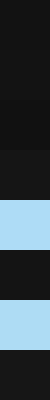

In [12]:
aff_palette(palette)

### Traitement de l'image

Dès lors on il suffit de parcourir tout les pixels de l'image et pour chacun des pixels :
<ul> 
    <li>Determiner quelle couleur de la palette est la plus proche de la couleur du pixel (au sens de la norme euclidienen)</li>
    <li>Remplacer la couleur du pixel pour la couleur en question</li>
</ul>

Pour ceci on utilise la fonction <code>recolor</code>

In [180]:
im_reocolored = recolor(im,palette)
im_reocolored.show()

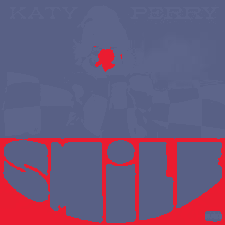

In [14]:
first_quantize("kattyp.jpeg", nb_couleurs_palette)


### Évaluer la performance de notre algorithme de quantification de couleur

Pour évaluer la performance de notre algorithme nous allons faire la moyenne de la norme au carré de la différence de la couleur de chaque pixel (et normalisée pour avoir une valeur comprise entre 0 et 1).entre les deux images. Cette évulation est réalisée par la foncion <code>score</code>. Par exemple notre image des <b>Beatles</b> optien un score de : $0.846$

In [15]:
score(im, im_reocolored)

0.824660896154261

Étudions maintenant l'évolution de notre score en fonction du nombre de couleurs dans la palette :

Pour réduire le temps de calcul nous utiliserons la fonction <code>first_quantize_no_sorting</code> qui ne trie pas la liste <code>l</code> mais la prend en argument, car le tri de la liste <code>l</code> est assez long.

In [16]:
l_score = []
for i in range(1,50):
    l_score.append(score(first_quantize_no_sorting("beatles.jpeg",l,i), Image.open("beatles.jpeg")))


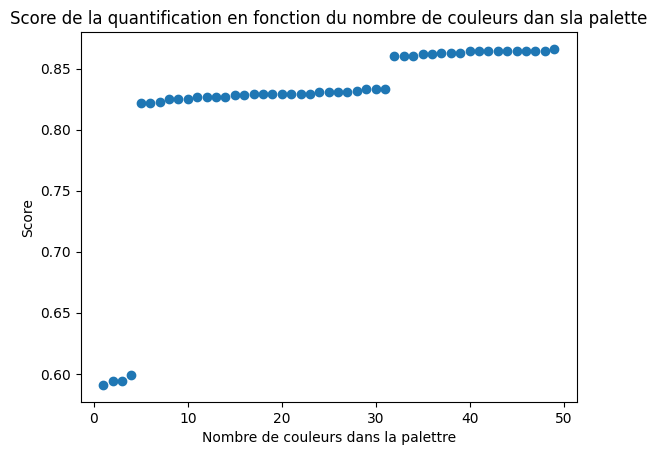

In [17]:
import matplotlib.pyplot as plt
plt.scatter(range(1,50),l_score)
plt.xlabel("Nombre de couleurs dans la palettre")
plt.ylabel("Score")
plt.title("Score de la quantification en fonction du nombre de couleurs dan sla palette")
plt.show()

On remarque ici une augmentation importante et soudaine du score entre 4 et 5 couleurs. Cette discontinuité s'explique par le choix des couleurs dans la palettes, en effet en fonction des images, nous somme amené à determiner une liste de couleurs triées par fréquence d'apparition dont les premières couleurs sont proches. Ainsi on pourrait choisir les <code>nb_couleurs_palette</code> de sortes qu'elles soient deux à deux distantes d'une valeur minimale.

Ce phénomène s'observe très bien avec une image de La Joconde:


In [107]:
first_quantize("j.jpeg", nb_couleurs_palette)

KeyboardInterrupt: 

### Choix aléatoire à 5%


In [19]:
lj = to_list_without_transp(Image.open("j.jpeg"))
lj = sort_list(lj)

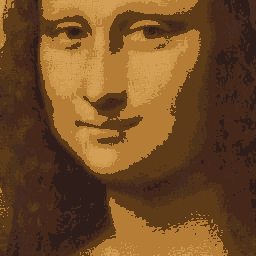

In [120]:
second_quantize_random("j.jpeg",lj,nb_couleurs_palette)

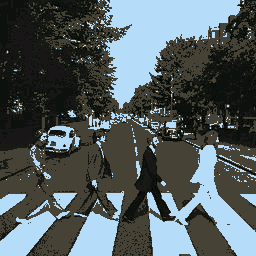

In [136]:
second_quantize_random("beatles.jpeg", l, nb_couleurs_palette)

In [179]:
scorebeatles = []
for i  in range(50) :
    scorebeatles.append(score(second_quantize_random("beatles.jpeg", l, nb_couleurs_palette),Image.open("beatles.jpeg")))

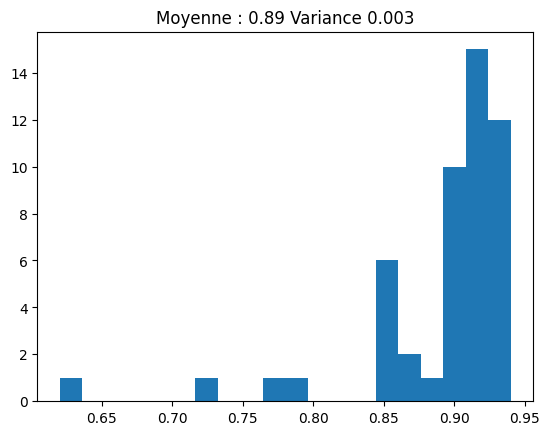

In [177]:
import statistics
plt.hist(scorebeatles, bins = 20)
plt.title(f"Moyenne : {round(statistics.mean(scorebeatles),3)} Variance {round(statistics.variance(scorebeatles),3)}")
plt.show()

In [186]:
lj = to_list_without_transp(Image.open("lp.jpeg"))
lj = sort_list(lj)
second_quantize_random("lp.jpeg", lj, nb_couleurs_palette).show()

In [187]:
score(second_quantize_random("lp.jpeg", lj, nb_couleurs_palette), Image.open("lp.jpeg"))

0.9552019510265953